# Training MNIST classifier using ScRRAMBLe

In [1]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm.notebook import tqdm
import pandas as pd

from utils import clipping_ste, intercore_connectivity, plot_connectivity_matrix, load_mnist
from models import ScRRAMBLeLayer, ScRRAMBLeClassifier


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.




import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap
import seaborn as sns

%load_ext autoreload
%autoreload 2

2025-05-13 18:46:04.764025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747187164.778128 1210237 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747187164.782336 1210237 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Defining a classifier

In [2]:
class ScRRAMBLeMNIST(nnx.Module):
    """
    MNIST Classifier using ScRRAMBLE architecture
    """

    def __init__(
        self,
        input_vector_size: int,
        input_cores: int,
        output_cores: int,
        avg_slot_connectivity: int, 
        slots_per_core: int,
        slot_length: int,
        activation: Callable,
        rngs: nnx.Rngs,
        group_size: int,
        core_length: int = 256,
        threshold: float = 0.0,
        noise_sd: float = 0.05,


    ):

        self.input_vector_size = input_vector_size
        self.input_cores = input_cores
        self.output_cores = output_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.rngs = rngs
        self.group_size = group_size
        self.core_length = core_length
        self.threshold = threshold
        self.noise_sd = noise_sd
        self.activation = partial(activation, threshold=threshold, noise_sd=noise_sd, key=rngs.activation())

        # define the scrramble layer
        self.scrramble_layer = ScRRAMBLeLayer(
            input_vector_size=input_vector_size,
            input_cores=input_cores,
            output_cores=output_cores,
            avg_slot_connectivity=avg_slot_connectivity,
            slots_per_core=slots_per_core,
            slot_length=slot_length,
            activation=activation,
            rngs=rngs,
            core_length=core_length,
            threshold=threshold,
            noise_sd=noise_sd
        )

    @partial(nnx.jit, static_argnames=['output_coding'])
    def __call__(self, x, output_coding: str = 'population'):
        """
        Forward pass for the ScRRAMBLe MNIST classifier
        Args:
            x: jax.Array, input data. Assumed to be flattened MNIST image. No batch.
            output_coding: str, specifies how the binary output should be interpreted. Choices are: ['population', 'svm', ...]. Only 'population' is implemented so far.
        Returns:
            out: jax.Array, output of calssifier with population coding applied. (batch_size, group_size)
        """

        # reshape the image
        # print(x.shape)
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')
        x = x.reshape(x.shape[0], -1)

        # using vmap do the forward pass
        y = nnx.vmap(self.scrramble_layer, in_axes=0)(x)

        # check if population coding is used
        if output_coding == 'population':

            # truncation
            y_reshaped = y.reshape(y.shape[0], y.shape[1], -1)
            y_reshaped = y_reshaped[..., :250]

            y_reshaped = y_reshaped.reshape(y_reshaped.shape[0], self.group_size, -1)
            y_reshaped = jnp.mean(y_reshaped, axis=-1)
            
            return y_reshaped
            
        else:
            raise NotImplementedError("Non-population coding not implemented yet.")
        

(10, 10)


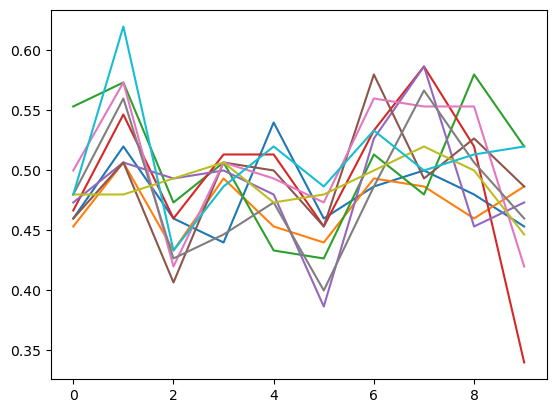

In [3]:
# testing forward pass through the model
rngs_test = nnx.Rngs(params=0, activation=1, permute=2)
x_test = jax.random.normal(rngs_test.params(), (10, 28, 28, 1))
model_test = ScRRAMBLeMNIST(
    input_vector_size=32*32,
    input_cores=5,
    output_cores=6,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs_test,
    group_size=10,
    core_length=256,
    threshold=0.0,
    noise_sd=0.05
)

nnx.display(model_test)
y_test = model_test(x_test)
print(y_test.shape)
plt.plot(y_test.T)

In [6]:
15360%100

60

## Define dataloaders

In [3]:
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 128,
    'train_steps': 5000,
    'binarize': True,
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 200,
}

train_ds, test_ds = load_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    binarize=dataset_dict['binarize'],
    greyscale=dataset_dict['greyscale'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    threshold=dataset_dict['threshold'],
)





I0000 00:00:1747187176.625052 1210237 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42789 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


2025-05-13 18:46:18.423783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


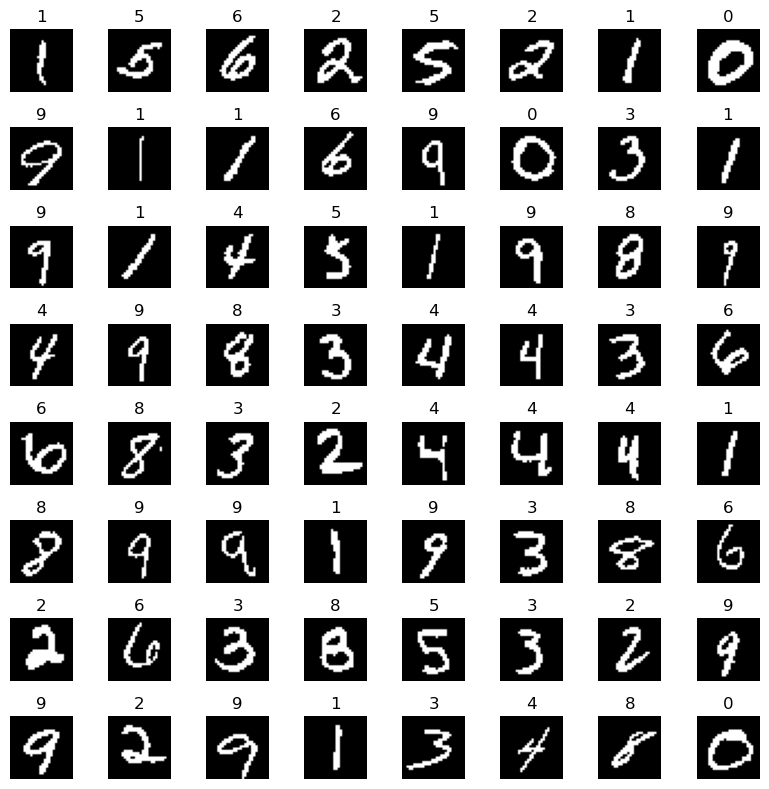

In [4]:
# plot the first batch
train_batch = train_ds.as_numpy_iterator().next()

fig, axs = plt.subplots(8, 8, figsize=(8,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"{train_batch['label'][i]}")
    ax.axis('off')

plt.tight_layout()

## Defining training functions


In [5]:
def loss_fn(model: ScRRAMBLeMNIST, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: ScRRAMBLeMNIST, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: ScRRAMBLeMNIST, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.


## Training pipeline

In [12]:
rngs = nnx.Rngs(params=0, activation=1, permute=2)
model = ScRRAMBLeMNIST(
    input_vector_size=32*32,
    input_cores=20,
    output_cores=12,
    avg_slot_connectivity=8,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs,
    group_size=10,
    core_length=256,
    threshold=0.0,
    noise_sd=0.05
)

# optimizers
hyperparameters = {
    'learning_rate': 5e-4,
    'momentum': 0.9, 
    'weight_decay': 1e-4
}

optimizer = nnx.Optimizer(
    model,
    optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
)

metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss')
)

nnx.display(optimizer)


In [13]:
metrics_history = {
'train_loss': [],
'train_accuracy': [],
'test_loss': [],
'test_accuracy': [],
}

eval_every = dataset_dict['eval_every']
train_steps = dataset_dict['train_steps']

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics

  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(f"Step {step}: Test loss: {metrics_history['test_loss'][-1]}, Accuracy: {metrics_history['test_accuracy'][-1]}")

best_accuracy = max(metrics_history['test_accuracy'])
print(f"Best accuracy: {best_accuracy}")

Step 200: Test loss: 1.5545234680175781, Accuracy: 0.8894230723381042
Step 400: Test loss: 1.5375065803527832, Accuracy: 0.903245210647583
Step 600: Test loss: 1.526100993156433, Accuracy: 0.9159655570983887
Step 800: Test loss: 1.5197087526321411, Accuracy: 0.9324920177459717
Step 1000: Test loss: 1.5134059190750122, Accuracy: 0.9349960088729858
Step 1200: Test loss: 1.5124815702438354, Accuracy: 0.9243789911270142
Step 1400: Test loss: 1.5082868337631226, Accuracy: 0.9428085088729858
Step 1600: Test loss: 1.5055863857269287, Accuracy: 0.9406049847602844
Step 1800: Test loss: 1.5050277709960938, Accuracy: 0.9476162195205688
Step 2000: Test loss: 1.502323031425476, Accuracy: 0.9476162195205688
Step 2200: Test loss: 1.5025898218154907, Accuracy: 0.9497195482254028
Step 2400: Test loss: 1.5008959770202637, Accuracy: 0.9528245329856873
Step 2600: Test loss: 1.5017316341400146, Accuracy: 0.9509214758872986
Step 2800: Test loss: 1.4995720386505127, Accuracy: 0.9541265964508057
Step 3000: Te

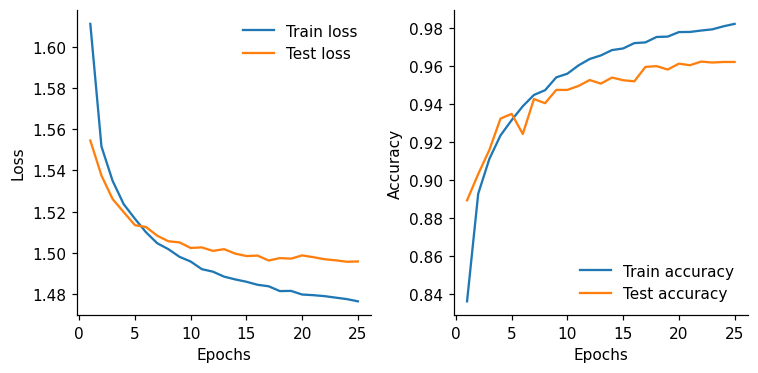

In [14]:
# plot the performance
fig, ax = plt.subplots(1, 2, dpi=110, figsize=(7, 3.5))
epo = jnp.arange(1, len(metrics_history['train_loss']) + 1, 1)
ax[0].plot(epo, metrics_history['train_loss'], label='Train loss')
ax[0].plot(epo, metrics_history['test_loss'], label='Test loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(frameon=False)

ax[1].plot(epo, metrics_history['train_accuracy'], label='Train accuracy')
ax[1].plot(epo, metrics_history['test_accuracy'], label='Test accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(frameon=False)

plt.tight_layout()
sns.despine()

## Evaluate role of weight-sharing

- For now 16-cores setup seeems to be giving about 95% accuracy.
- First we evalualte how weight sharing changes the performance.

### Resample strategy:
- Pick $\lambda$: average slot connectivity.
- Pick configuration of cores:
    - Set a budget for number of available cores: $N_c$.
    - Pick input cores from a uniform distribution $N_c^i \sim \mathcal{U} [4, 12]$
    - The number of output cores are $N_c^o = N_c - N_c^i$.

- This way we account for the role of weight sharing in a given budget of cores


In [ ]:
# number of resamples
n_resamples = 10

# budget of cores
n_cores = 16
ni_list = [8, 10, 12]
no_list = [n_cores - ni for ni in ni_list]
in_out_list = [(ni, no) for ni, no in zip(ni_list, no_list)]

# avg connectivities
avg_conn_list = jnp.arange(1, 10, 1).tolist()

# redefining the hyperparameters
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 64,
    'train_steps': 1000,
    'binarize': True,
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 200,
}

# optimizers
hyperparameters = {
    'learning_rate': 5e-4,
    'momentum': 0.9, 
    'weight_decay': 1e-2
}

# architecture dict
arch_dict = {
    'arch' : [],
    'test_accuracy': [],
    'train_accuracy': [],
    'test_loss' : [],
    'train_loss' : [],
    'avg_slot_connectivity': []
}

train_ds, test_ds = load_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    binarize=dataset_dict['binarize'],
    greyscale=dataset_dict['greyscale'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    threshold=dataset_dict['threshold'],
)


key1 = jax.random.key(134)

# architecture loop
for idx, a in tqdm(enumerate(in_out_list), total=len(in_out_list), desc="Architecture loop"):
    no, ni = a

    # average connectivity loop
    for lam in tqdm(avg_conn_list, total=len(avg_conn_list), desc=r"Connectivity loop"):

        # resample loop
        for r in tqdm(range(n_resamples), desc="Resampling loop"):
            key1, key2, key3 = jax.random.split(key1, 3)
            rng = nnx.Rngs(params=key1, activation=key2, permute=key3)

            # define the model and optimizer
            model = ScRRAMBLeMNIST(
                input_vector_size=32*32,
                input_cores=ni,
                output_cores=no,
                avg_slot_connectivity=lam,
                slots_per_core=4,
                slot_length=64,
                activation=clipping_ste,
                rngs=rng,
                group_size=10,
                core_length=256,
                threshold=0.0,
                noise_sd=0.05
            )

            optimizer = nnx.Optimizer(model, optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay']))
            metrics = nnx.MultiMetric(accuracy=nnx.metrics.Accuracy(), loss=nnx.metrics.Average('loss'))

            # training loop
            metrics_history = {
            'train_loss': [],
            'train_accuracy': [],
            'test_loss': [],
            'test_accuracy': [],
            }

            eval_every = dataset_dict['eval_every']
            train_steps = dataset_dict['train_steps']

            for step, batch in tqdm(enumerate(train_ds.as_numpy_iterator()), total=len(train_ds), desc="Training loop"):
                # Run the optimization for one step and make a stateful update to the following:
                # - The train state's model parameters
                # - The optimizer state
                # - The training loss and accuracy batch metrics

                train_step(model, optimizer, metrics, batch)

                if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
                    # Log the training metrics.
                    for metric, value in metrics.compute().items():  # Compute the metrics.
                        metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
                    metrics.reset()  # Reset the metrics for the test set.

                    # Compute the metrics on the test set after each training epoch.
                    for test_batch in test_ds.as_numpy_iterator():
                        eval_step(model, metrics, test_batch)

                    # Log the test metrics.
                    for metric, value in metrics.compute().items():
                        metrics_history[f'test_{metric}'].append(value)
                    metrics.reset()  # Reset the metrics for the next training epoch.

                    # print(f"Step {step}: Test loss: {metrics_history['test_loss'][-1]}, Accuracy: {metrics_history['test_accuracy'][-1]}")

            # get the best metrics 
            best_test_accuracy = max(metrics_history['test_accuracy'])
            best_train_accuracy = max(metrics_history['train_accuracy'])
            best_test_loss = min(metrics_history['test_loss'])
            best_train_loss = min(metrics_history['train_loss'])
            arch_dict['arch'].append(idx)
            arch_dict['test_accuracy'].append(float(best_test_accuracy))
            arch_dict['train_accuracy'].append(float(best_train_accuracy))
            arch_dict['test_loss'].append(float(best_test_loss))
            arch_dict['train_loss'].append(float(best_train_loss))
            arch_dict['avg_slot_connectivity'].append(int(lam))
            print(f"Architecture: {in_out_list[idx]}, Avg. connectivity = {lam}, Test accuracy: {best_test_accuracy}, Train accuracy: {best_train_accuracy}")


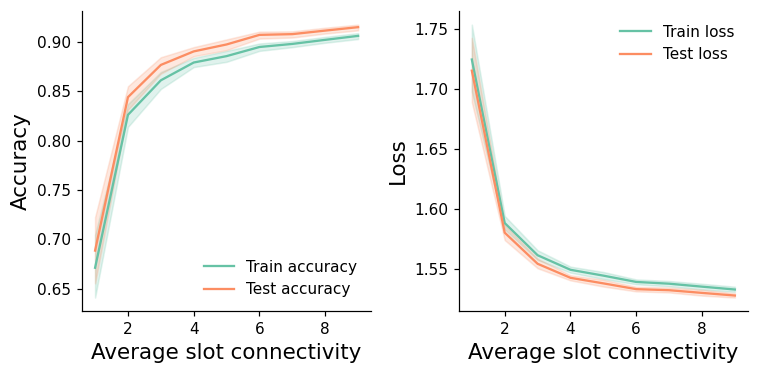

In [67]:
## plotting the results
arch_df = pd.DataFrame(arch_dict)
arch_df['train_accuracy'] = arch_df['train_accuracy'].astype(float)
arch_df['test_accuracy'] = arch_df['test_accuracy'].astype(float)
arch_df['test_loss'] = arch_df['test_loss'].astype(float)
arch_df['train_loss'] = arch_df['train_loss'].astype(float)
arch_df['avg_slot_connectivity'] = arch_df['avg_slot_connectivity'].astype(int)

pal1 = sns.color_palette("Set2", len(arch_df['arch'].unique()))

fig, ax = plt.subplots(1, 2, dpi=110, figsize=(7, 3.5))
sns.lineplot(data=arch_df, x='avg_slot_connectivity', y='train_accuracy', err_style='band', ax=ax[0], color=pal1[0], label='Train accuracy')
sns.lineplot(data=arch_df, x='avg_slot_connectivity', y='test_accuracy', err_style='band', ax=ax[0], color=pal1[1], label='Test accuracy')
ax[0].set_xlabel(r"Average slot connectivity", fontsize = 14)
ax[0].set_ylabel(r"Accuracy", fontsize = 14)
ax[0].legend(frameon=False)

sns.lineplot(data=arch_df, x='avg_slot_connectivity', y='train_loss', err_style='band', ax=ax[1], label="Train loss", color=pal1[0])
sns.lineplot(data=arch_df, x='avg_slot_connectivity', y='test_loss', err_style='band', ax=ax[1], label="Test loss", color=pal1[1])
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"Average slot connectivity", fontsize = 14)
ax[1].set_ylabel(r"Loss", fontsize = 14)

plt.tight_layout()
sns.despine()

/tmp/ipykernel_2357822/3612221355.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([(8, 8), (10, 6), (12, 4)])


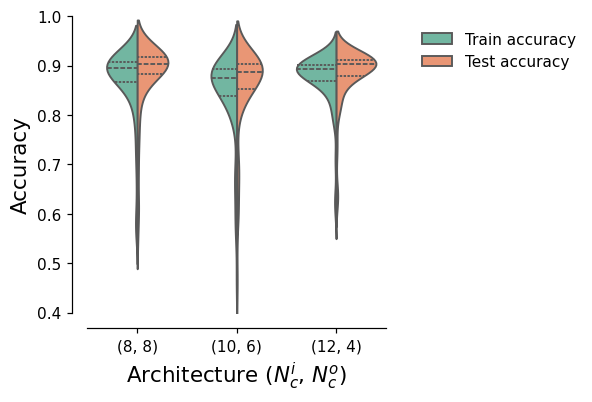

In [72]:
# plotting accuracies for every architecture
melt_df = pd.melt(
    arch_df,
    id_vars=['arch', 'test_loss', 'train_loss', 'avg_slot_connectivity'],
    value_vars=['train_accuracy', 'test_accuracy'],
    var_name='accuracy_type',
    value_name='accuracy'
)

melt_df.head()

label_mapping = {
    'train_accuracy': 'Train accuracy',
    'test_accuracy': 'Test accuracy'
}

melt_df['accuracy_type'] = melt_df['accuracy_type'].map(label_mapping)

pal_set2 = sns.color_palette("Set2", 2)
fig, ax = plt.subplots(dpi=110, figsize=(3.5, 3.5))
sns.violinplot(
    data=melt_df,
    x='arch',
    y='accuracy',
    hue='accuracy_type',
    palette=pal_set2,
    split=True,
    inner='quartile',
)

ax.set_ylim(0.4, 1)
ax.set_xticklabels([(8, 8), (10, 6), (12, 4)])
ax.set_xlabel(r"Architecture ($N_c^i$, $N_c^o$)", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
# ax.set_xlim(0, 2)
ax.legend(title='', loc=(1.1, 0.8), frameon=False)
sns.despine(offset=10)

Index(['arch', 'test_accuracy', 'train_accuracy', 'test_loss', 'train_loss',
       'avg_slot_connectivity'],
      dtype='object')